# Grouptimus Prime
## Phase 2 Project

In [1]:
#Importing libraries 
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import cross_validate, ShuffleSplit,train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyRegressor
import warnings

%matplotlib inline

In [4]:
#Import dataset
dataset = pd.read_csv('../data/kc_house_data.csv')

## Cleaning the dataset

In [5]:
# Filling nulls with most common value
dataset['waterfront'] = dataset['waterfront'].fillna(0) 
# Drop how many times house viewed
dataset.dropna(subset = ['view'], inplace = True)
# Make values with no house renovation the year it was built
dataset.yr_renovated.fillna(dataset.yr_built, inplace=True)
# Make Zipcode a str
#dataset['zipcode'].astype(int)
# Make sqft basement a float and fill na with 0 
dataset['sqft_basement'] = dataset['sqft_basement'].replace('?', np.nan).astype(float).fillna(0)

# Heatmap for a quick look at where we might start

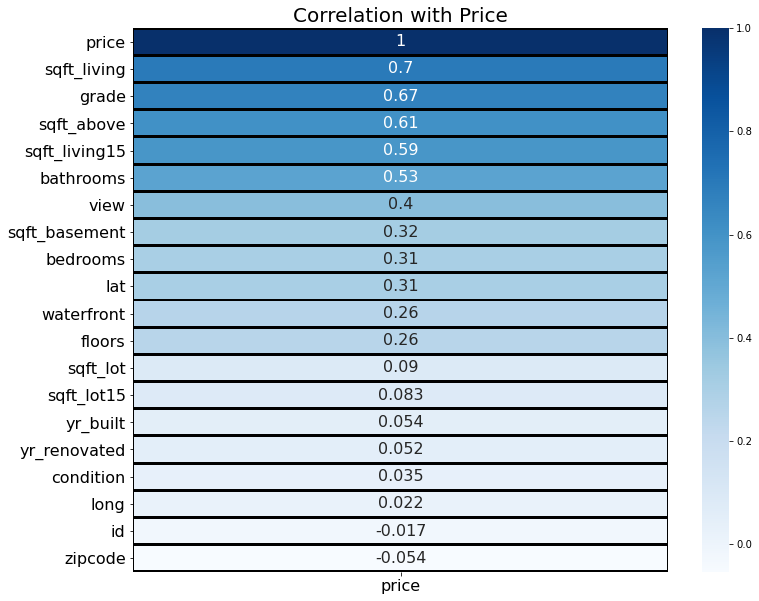

In [6]:
corr = dataset.corr()

x=corr[['price']]

fig , ax = plt.subplots(figsize=(12,10))

sns.heatmap(x.sort_values(by=['price'],ascending=0),
                          annot=True,
                          cmap='Blues',
                          annot_kws={'fontsize':16},
                          linewidth=2,
                          linecolor='black')
ax.set_title('Correlation with Price',size=20)
ax.tick_params(labelsize=16)

 It seems like sqft_living has the highest correlation with price. This and grade seem to be the two highest, but grade is categorical (technically) and sqft is numerical.

# Looking at score with most correlated feature

Here we run a first model to see where we are.

In [7]:
X = dataset['sqft_living']
y= dataset['price']
#Splitting our data into train sets and test sets

X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Have to reshape in order for test to work
X_train = np.array(X_train).reshape(-1,1)
Y_train = np.array(Y_train).reshape(-1,1)
X_test = np.array(X_test).reshape(-1,1)
Y_test = np.array(Y_test).reshape(-1,1)


model = LinearRegression()
model.fit(X_train,Y_train)

Y_pred = model.predict(X_test)

model.coef_,model.intercept_,model.score(X_train,Y_train),metrics.r2_score(Y_pred,Y_test)

(array([[275.11242933]]),
 array([-33400.22237015]),
 0.48393292680670863,
 -0.0759944896898821)

This model performed poorly. We will need to look at other features.

# Exploring Price Data

C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


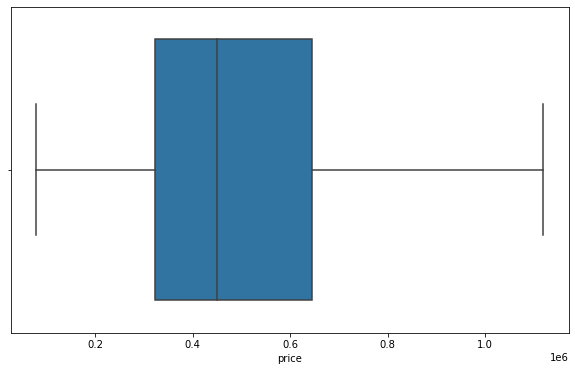

In [8]:
#Checking the distribution of house prices
fig, ax = plt.subplots(figsize = (10, 6))
sns.boxplot(dataset['price'], showfliers = False)
warnings.filterwarnings('ignore')
#ax.set_xticks()-- Seth took this project

# Exploration of grade

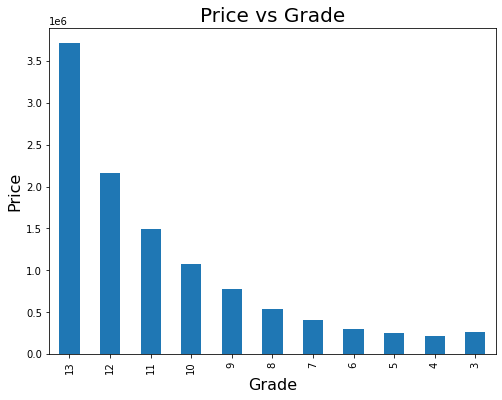

In [9]:
columns = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','condition','grade','sqft_living15','sqft_lot15']
df_grade = dataset.groupby('grade').mean().sort_values(by=['grade'],ascending=False)
grade_df = pd.DataFrame(df_grade,columns=columns)


price_df = grade_df['price']
fig ,ax = plt.subplots(figsize=(8,6))

price_df.plot.bar()
ax.set_title('Price vs Grade',fontsize=20)
ax.set_ylabel('Price',fontsize=16)
ax.set_xlabel('Grade',fontsize=16);

The trend appears to be the higher the grade of the house, the higher the price is. This will be a good variable to help predict the price of houses.

# Test Two Highest Correlated Features

In [10]:
X = pd.DataFrame(dataset,columns = ['sqft_living','grade'])
y = dataset['price']

In [11]:
#Split Data into training and test sets

X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use a scaler for our X values
Scaler = StandardScaler()
X_train = Scaler.fit(X_train).transform(X_train)

#Fit Training data to linear model
model = LinearRegression()
model.fit(X_train,Y_train)

# Predict the Y outcomes off our test set
Y_pred = model.predict(Scaler.transform(X_test))

model.coef_,model.intercept_,model.score(X_train,Y_train) , metrics.r2_score(Y_pred,Y_test) 

(array([161557.97705503, 117903.51066484]),
 538633.7840599059,
 0.5287634782087913,
 0.0796166738600097)

In [12]:
formula2 = 'price ~ sqft_living + grade '
model = ols(formula2, data=dataset)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                 1.237e+04
Date:                Thu, 26 Aug 2021   Prob (F-statistic):               0.00
Time:                        23:00:56   Log-Likelihood:            -2.9818e+05
No. Observations:               21534   AIC:                         5.964e+05
Df Residuals:                   21531   BIC:                         5.964e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -6.022e+05   1.33e+04    -45.236      0.000   -6.28e+05   -5.76e+05
sqft_living   183.0118      2.866     63.851      0.000     177.394     188.630
grade        9.946e+04   2242.475     44.353      0.000    9.51e+04    1.04e+05
==============================================================================
Omnibus:                    16729.440   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           963595.898
Skew:                           3.257   Prob(JB):                         0.00
Kurtosis:                      35.117   Cond. No.                     1.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model shows improvements, but more investigation is needed.

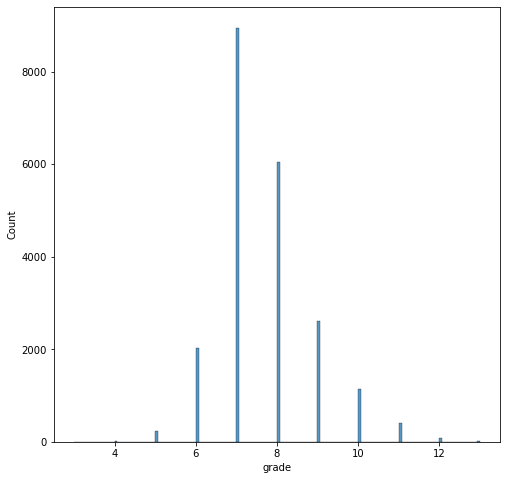

In [13]:
fig , ax = plt.subplots(figsize=(8,8))

sns.histplot(dataset['grade']);

After graphing, we can see that grade is a categorical variable and we will need to create dummy variables. 

In [14]:
# Creating dummy columns for grade variable, and
# then joined our original dataset with dummy columns
dummy_df = dataset['grade']
dummies = pd.get_dummies(dummy_df,prefix='grade',drop_first=True)
merged = pd.concat([dataset,dummies],axis=1)
merged.drop('grade',axis=1,inplace=True)

# Investigating zip codes

In [15]:
# Replaced zip code values with the mean price of the entire zip code
df_zip = dataset.groupby('zipcode').mean().sort_values(by=['price'],ascending=False)
columns = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','condition','grade','sqft_living15','sqft_lot15']
new_df = pd.DataFrame(df_zip,columns=columns)
new_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,condition,grade,sqft_living15,sqft_lot15
zipcode,,,,,,,,,
98039,2.161300e+06,4.060000,3.200000,3800.900000,17403.560000,3.480000,9.560000,3132.200000,17291.100000
98004,1.358522e+06,3.857595,2.530063,2913.069620,13117.208861,3.496835,8.693038,2677.215190,12817.063291
98040,1.183231e+06,4.025090,2.709677,3097.265233,13674.465950,3.784946,8.949821,2893.928315,12751.035842
98112,1.094695e+06,3.507463,2.370336,2494.410448,4987.410448,3.518657,8.436567,2276.496269,4894.794776
98102,8.996077e+05,3.250000,2.283654,2151.048077,3605.153846,3.375000,8.298077,1954.471154,3303.500000
...,...,...,...,...,...,...,...,...,...
98148,2.849086e+05,3.140351,1.793860,1610.526316,8960.719298,3.070175,6.947368,1611.228070,8812.385965
98001,2.808812e+05,3.392758,2.013231,1901.743733,14978.727019,3.337047,7.292479,1829.292479,11230.228412
98032,2.510172e+05,3.379032,1.709677,1738.435484,10401.169355,3.629032,7.145161,1668.459677,9284.290323


We will use the average price per zip code to help predict price of houses


# Early Model Exporing Features

In [16]:
#Adding condition to see if any major improvements are found
X=merged.drop(['id','date','lat','yr_renovated','long','view','sqft_lot','grade_13','sqft_above','sqft_living15','price',
               'bathrooms','sqft_lot15','yr_built','bedrooms','sqft_basement','floors','condition'], axis = 1).select_dtypes(exclude = ['object', 'category'])
y = merged['price']

X_train,X_test,Y_train,Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
ss = StandardScaler()
ss.fit(X).transform(X)

model.fit(X,y)

y_hat = model.predict(X_test)

resid = Y_test-y_hat

model.coef_,model.intercept_,model.score(X_train,Y_train), metrics.r2_score(y_hat,Y_test) 

(array([ 1.58224394e+02,  7.76694757e+05,  5.59543723e+02, -2.24758460e+06,
        -2.27964660e+06, -2.26131022e+06, -2.22612415e+06, -2.16131379e+06,
        -2.03634022e+06, -1.85154119e+06, -1.57957703e+06, -1.11441710e+06]),
 -52521809.43193704,
 0.6093554251778308,
 0.3861187457848757)

This model explores sqft_living, waterfront, zipcode and grades as dummy variables. It shows a good improvement on our test data.

# A Finalized Model

In [17]:

merged = merged[merged['price'] < 1200000]

#Create a column that has age of house
merged['house_age'] = 2014 - merged['yr_built']

X=merged.drop(['id','date','view','sqft_lot','grade_13','sqft_above','sqft_living15','grade_7','yr_built'
               ,'sqft_lot15','sqft_basement','floors','condition'], axis = 1).select_dtypes(exclude = ['object', 'category'])
y = merged['price']

In [18]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#To avoid data leakage, the average price of zip codes is obtained only from the training set of data.
group = X_train.groupby('zipcode').mean().sort_values(by=['price'],ascending=False)
zip_group = group['price']

# Put values into a dictionary, then map a new column matching the average price of that zip code
zip_dict = zip_group.to_dict()
X_train['avg_zip_price'] = X_train['zipcode'].map(zip_dict)
warnings.filterwarnings('ignore')

In [19]:
# We put this data into the test set to make equal columns to run the test
X_test['avg_zip_price'] = X_test['zipcode'].map(zip_dict)

#Drop Price from both test and train sets
#X_test.drop('price',inplace=True,axis=1)
#X_train.drop('price',inplace=True,axis=1)
warnings.filterwarnings('ignore',category=DeprecationWarning)

In [20]:
#Average price of bedrooms mapped to it's own column
group2 = X_train.groupby('bedrooms').mean().sort_values(by=['price'],ascending=False)
bedrooms_group = group2['price']
bed_dict = bedrooms_group.to_dict()
X_train['beds'] = X_train['bedrooms'].map(bed_dict)



In [21]:
# To avoid data leakage, use only the average from the training set and apply to testing set
X_test['beds'] = X_test['bedrooms'].map(bed_dict)
X_test.drop('price',inplace=True,axis=1)
X_train.drop('price',inplace=True,axis=1)

In [22]:
# Check for Colinearity
vif = pd.DataFrame()
X = pd.DataFrame(X_train,columns=X_train.columns)
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,1.111190e+02,bedrooms
1,2.597327e+01,bathrooms
2,2.762428e+01,sqft_living
3,1.012845e+00,waterfront
4,1.276046e+00,yr_renovated
5,1.423328e+06,zipcode
6,2.105799e+05,lat
7,1.257232e+06,long
8,1.011746e+00,grade_4
9,1.082552e+00,grade_5


# A visual Representation of our Predicted Values vs the Actual Values

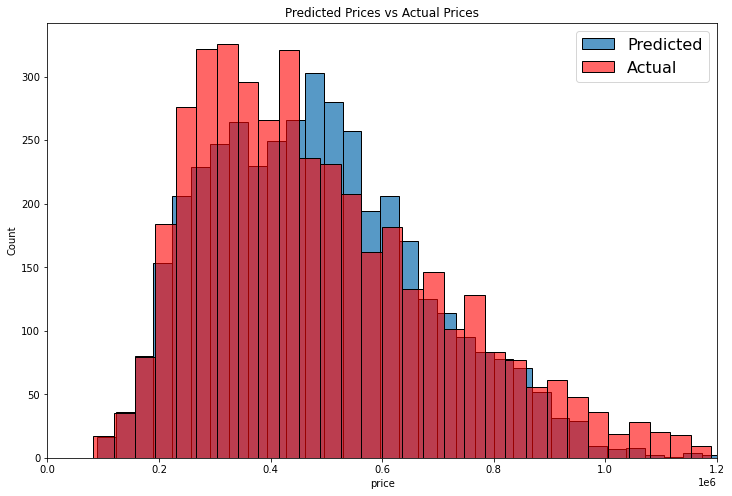

In [23]:
fig , axes = plt.subplots(nrows=1,ncols=1,figsize=(12,8))

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sns.histplot(y_pred,ax=axes,label='Predicted')
sns.histplot(y_test,color='red',alpha=.6,label='Actual')
axes.set_xlim([0,1200000])
axes.set_xlabel('price')
axes.set_title('Predicted Prices vs Actual Prices')
plt.legend(fontsize=16);
plt.savefig('Predicted vs Actual Stacked')


In [24]:
# Standard Test Cell

Scaler = StandardScaler()
X_train = Scaler.fit_transform(X_train)
X_test = Scaler.transform(X_test)

final_model = LinearRegression()
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
final_model.coef_, final_model.intercept_, final_model.score(X_train, y_train), final_model.score(X_test, y_test)

(array([ -4626.40430629,  15935.9492453 ,  80412.30831616,  15555.61579834,
          1668.67036427,   2262.88155283,  12935.83977656, -18388.89913162,
         -2349.66733674,  -5956.89898986, -12561.51926298,  24135.60403484,
         44275.40337655,  35849.49340081,  23424.01847634,   2760.92778588,
         36622.14549194, 102839.88950011,  -1196.94494242]),
 479651.25925925816,
 0.795486600797327,
 0.8014425193775458)

Location seems to play  a big part in the price of a house. Using zip code to help with pricing allows us to explain 79% of variance in the prices of houses.

# Investigating Linearity

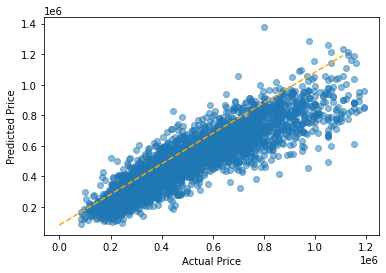

In [25]:
preds = final_model.predict(X_test)
fig, ax = plt.subplots()

perfect_line = np.arange(y_test.min(), y_test.max())
ax.plot(perfect_line, linestyle = '--', color = 'orange', label = "Perfect Fit")
ax.scatter(y_test, preds, alpha=.5)
ax.set_xlabel("Actual Price")
ax.set_ylabel("Predicted Price");

# Investigating Normality

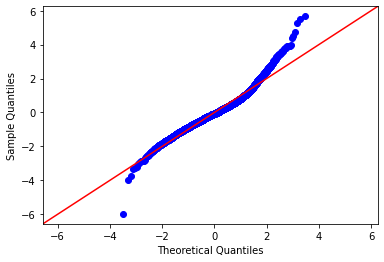

In [26]:
residuals = (y_test - y_pred)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

# Investigating Homoskedasticity

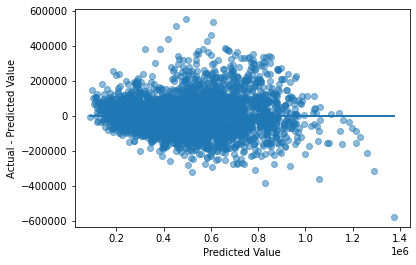

In [27]:
fig, ax = plt.subplots()

ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_test))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");